# Tutorial - Getting Started with IFM

This tutorial introduces you to the high-level concepts for using FEFLOW using its Python API (IFM).

It is assumed that you have basic knowledge about using the Python language.

[<< Back to index](0-index.ipynb)

[>> Next : Data Wrangling with Pandas and Geopandas](2-data-wrangling-in-python.ipynb)

## Installation

The Python API is installed together with FEFLOW, provided that the respective option was set during the installation.
The FEFLOW installer 
+ installs the IFM API module below the FEFLOW program folder in a `/python/ifm` subfolder and 
+ adds this folder to the search path.

**Multiple FEFLOW Versions**

Note that if there are multiple versions of FEFLOW installed, it depends on the order of their entry in the search path list which one will be loaded.

An example is shown below, with three FEFLOW installations (7.2, 7.4 and 7.5).

In [1]:
import sys
sys.path[:7]

['C:\\Program Files\\DHI\\2022\\FEFLOW 7.5\\python',
 'C:\\Program Files\\DHI\\2021\\FEFLOW 7.4\\python',
 'C:\\Program Files\\DHI\\2019\\FEFLOW 7.2\\python',
 'c:\\Anaconda3\\envs\\py36_dhi_imageproc\\python36.zip',
 'c:\\Anaconda3\\envs\\py36_dhi_imageproc\\DLLs',
 'c:\\Anaconda3\\envs\\py36_dhi_imageproc\\lib',
 'c:\\Anaconda3\\envs\\py36_dhi_imageproc']

The API of 7.5 will be imported, as it is the first occurence.

In [2]:
import ifm
ifm.getKernelVersion()

7460

If you want to import a a different version, you need to remove the entry from the search path (e.g. `sys.path.pop(0)` will remove the topmost entry) befor calling `import ifm`.

## Pre- and Postprocessing

Automating Pre- and Postprocessing is usually the most frequent usage of the IFM API. It includes loading a model, chaning model settings, running the model, and evaluating model results.

Note that there is a second use case, where code is injected in the simulation at runtime using callbacks, which is discussed further below.

### Loading a model

To load a model, the ifm module provides the `ifm.loadDocument` method. The method returns an object representing the FEFLOW model. 

In [3]:
doc = ifm.loadDocument("./example_data/BoxB.fem")

The doc object is the central object of the API, as it provides numerous functions that alles to read or apply new model properties. More examples will be shown further below, in this case we will simply start the simulator and write the results to a dac file:

### Running a model

The following command starts the simulation

In [4]:
doc.startSimulator("./example_data/BoxB.dac")

This command is equivalent to starting the simulation in the GUI. Note that the API allows more refined options, namely `doc.runTo()`, which starts the simulation but pauses it at a given simulation time, and `doc.singleStep()`, which advances the simulation by one time step and then Pauses the simulation again.

### Stopping the Simulation and Closing the model

To end the script in a tidy manner, the simulator is stopped and the model is closed.
This will free up resources ressources on your computer and will free up the license used.

In [5]:
doc.stopSimulator() 
doc.closeDocument()

## Reading and Changing Model Propertoies 

The `ifm.FeflowDocument` class (typically instantiated as `doc`) is the central object in an IFM script.

It exposes a large number of member functions that allow making various changes in the model, these functions are members of the doc object. The following example opens the model again and reads the amount of nodes and elements from the model:

In [6]:
doc = ifm.loadDocument("./example_data/BoxB.fem")
print(f"number of nodes:    {doc.getNumberOfNodes()}")
print(f"number of elements: {doc.getNumberOfElements()}")

number of nodes:    565
number of elements: 1043


Other functions allow aspects to the following aspects of the model (list is not complete): 
+ model properties (boundary conditions, material parameters, user and auxilliary data).
+ initial conditions and model results
+ discrete features
+ budgets
+ history charts and time series
+ selections
+ numerical settings
+ particle tracing
+ and more.

A complete reference to the API can be found under [dhi.github.io/ifm](dhi.github.io/ifm).

## Examples

### Example 1: Batch Processing of FEFLOW models

The following code is a simple batch executor that auto-detects all fem-files in a given folder, run the simulator for each one and save its results in a dac-file.

The `glob` object is used to find all files matching its search pattern and returns a list of its file paths.
It then iterates over the list and opens, runs, stops and closes the simulator as shown above:

In [7]:
import glob

# iterate filenames
for filename in glob.glob("./*.fem"):
    print(filename)
    
    # open, run, stop and close model
    doc = ifm.loadDocument(filename)
    doc.startSimulator(filename.replace(".fem", ".dac"))
    doc.stopSimulator()
    doc.closeDocument()

.\BoxB-1.fem
.\BoxB-2.fem
.\BoxB-20.fem
.\BoxB-4.fem
.\BoxB-8.fem


### Example 2: Create Scenarios of the same model

This example will open a feflow model, and will generate multiple scenarios by changing the pump rate of a well.

The model is a simple box model (2D, confined, steady state), whith a fixed head along one of its sides and a single well in the middle.

A nodal selection with name *well* is present that contains the well node as its single member. This selection will be evaluated by the script to determine the correct node number.

The well rate is applied (using the `setBcFlowValueAtCurrentTime` method), then the model is saved and run.

Finally, some automatic postprocesing is performed, where we iterate all nodes to find the lowest hydraulic head (=maximum drawdown). The result is printed to screen.

In [8]:
# load the base model
doc = ifm.loadDocument("./example_data/BoxB.fem")

# get the list of node indices in the 'well' selection, and then read its first (and only) member
nodes = doc.getSelectionItems(ifm.Enum.SEL_NODAL, "well")
n = nodes[0]

# iterate through a list of given pumping rates to be applied
for pump_rate_m3d in [1,2,4,8,20]:
    
    # set the pumping rate as the 4th kind BC value at the well
    doc.setBcFlowValueAtCurrentTime(n, pump_rate_m3d)
    
    # save the document (as a fem), then run it (create a dac-file). Add the pump rate to the file names.
    doc.saveDocument(f"./example_data/BoxB-{pump_rate_m3d}.fem")
    doc.startSimulator(f"./example_data/BoxB-{pump_rate_m3d}.dac")
    
    # find the minimum head in the model for this scenario
    min_head = 0
    for m in range(doc.getNumberOfNodes()):
        h = doc.getResultsFlowHeadValue(m) 
        if h < min_head:
            min_head = h
    print(f"{pump_rate_m3d} m3/d -> {min_head} m")
    
    # stop the simulator before going to the next iteration
    doc.stopSimulator()
    
# close the document
doc.closeDocument()

1 m3/d -> -1.1705378355047595 m
2 m3/d -> -2.341075671009519 m
4 m3/d -> -4.682151342019038 m
8 m3/d -> -9.364302684038076 m
20 m3/d -> -23.410756710095185 m


## Code-injection at model runtime

The above examples are typical pre- and postprocessing examples. In this case, FEFLOW is instructed via its IFM API to perform the desired actions. This is useful to automate the process for the sake of time savings and error prevention.

A fundamentally different use case for the Python API is that it can also be applied to enhance the capabilities of FEFLOW at model runtime, meaning that additional features can programmed that are executed **during** the model run.

This is possible by defining **call-back** functions, which FEFLOW will call automatically during a model run.

### Example 3: Open-Loop geothermal system

A typical application of this feature is the usage in an open-loop geothermal system.

These kind of systems extract water from an abstraction well, add or remove heat and then reinject the water in a separate injection well. The temperature at the injection well must be calculated considering the abstraction temperature and has to be set before each time step. This procedure is coded below and injected into the simulation sequence before the heat transport model is solved. 

In [9]:
# load the same model again
doc = ifm.loadDocument("./example_data/2D_heatload.fem")

# set the temperature delta here
delta_T = 1  # K

In [10]:
# get node of injection and extraction well
n_extraction = doc.getSelectionItems(ifm.Enum.SEL_NODES, "extraction")[0]
n_injection = doc.getSelectionItems(ifm.Enum.SEL_NODES, "injection")[0]
print(f"node {n_extraction} -> {n_injection}")

node 134 -> 332


In [11]:
def postFlowSimulation(doc, phase=1):
    """
    Callback function for FEFLOW
    This updates the boundary condition after the flow simulation has finished a time step.
    """
    
    # get flow and heat budgets at wells
    T_in = doc.getResultsTransportHeatValue(n_extraction)
    
    # calculate injection temperature
    T_out = T_in + delta_T
    
    # apply the injection temperature as the new boundary condition 
    doc.setBcHeatValueAtCurrentTime(n_injection, T_out)
    
    # print Tin, Tout and simulation time to screen
    print(f"Tin = {T_in:.2f}C\t -> Tout = {T_out:.2f}C \t@ {doc.getAbsoluteSimulationTime():2f} days")
    

When now starting the simulation, FEFLOW will check if the function `postFlowSimulation()` is defined, and execute it after the flow simulation step if this is the case.

In [12]:
doc.startSimulator()

Tin = 10.00C	 -> Tout = 11.00C 	@ 0.001000 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000513 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000364 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000305 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000191 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000120 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000075 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000047 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000030 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000019 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000012 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000007 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000005 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000003 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000002 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000001 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000011 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000003 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000002 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.000002 days
Tin = 10.00C	 -> Tout = 11.00C 	@ 0.0000

Once we have made sure this code is doing what it should, it can be permanently embedded into a FEFLOW model by pasting it into the script section of the scripting menu:

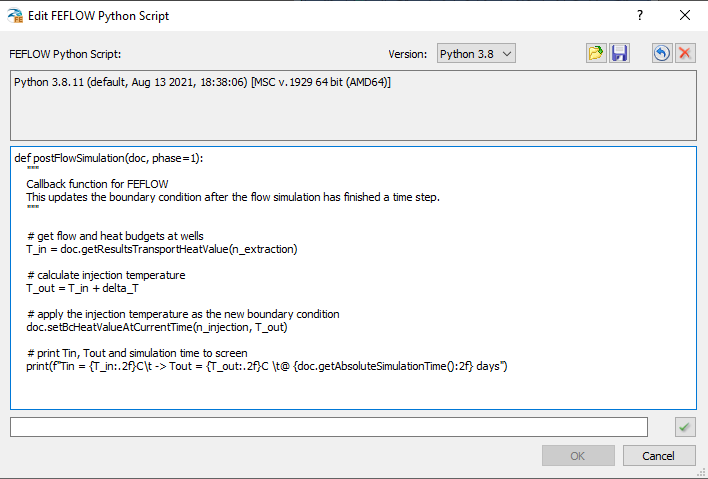
